In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
# Add project root to path - adjust the number of parent dirs (..) based on where your notebook is located
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import src.visualization as vis
import src.utils as utils
from src.utils import PacmanDataReader
import src.analysis as analysis

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [3]:
data = PacmanDataReader(data_folder='../data/', read_games_only=True)


Observations regarding trajectories, most of them can be seen in the example below:
- Trajectories don't necessarily start at the same time or position (even though they should). 
- Trajectories don't necessarily have the same length.
- Sampling time is not consistent. It should be every 50 ms, but sometimes it's shorter or longer. However, weirdly the timing between two consecutive samples is consistent (100 ms) (i.e, if one sample has a dt of 0.03 s, the next one will have a dt of 0.07 s).
- Velocities are not the same, they vary between levels (i.e, level 2 is faster than level 1).


In [4]:
ts1 = data.get_trajectory_dataframe(game_id=993).reset_index(drop=True) # game 993 is played on level 4

ts1['dx'], ts1['dy'] = utils.calculate_velocities(np.array(ts1[['Pacman_X', 'Pacman_Y']]), round=False)

ts1['dt'] = np.diff(ts1['time_elapsed'], prepend=ts1['time_elapsed'].iloc[0])

ts1['dx'] = ts1['dx'] / ts1['dt']
ts1['dy'] = ts1['dy'] / ts1['dt']

ts2 = data.get_trajectory_dataframe(game_id=990).reset_index(drop=True) # game 990 is played on level 1

ts2['dx'], ts2['dy'] = utils.calculate_velocities(np.array(ts2[['Pacman_X', 'Pacman_Y']]), round=False)

ts2['dt'] = np.diff(ts2['time_elapsed'], prepend=ts2['time_elapsed'].iloc[0])
ts2['dx'] = ts2['dx'] / ts2['dt']
ts2['dy'] = ts2['dy'] / ts2['dt']


ds = pd.concat([ts1, ts2], axis=1).reset_index(drop=True)
ds

,game_id,time_elapsed,Pacman_X,Pacman_Y,dx,dy,dt,game_id,time_elapsed,Pacman_X,Pacman_Y,dx,dy,dt
0,993.0,0.18,1.534140,-9.326811,NaN,NaN,0.00,990,0.200000,1.485321,-9.489613,NaN,NaN,0.000000
1,993.0,0.23,1.476429,-9.005260,-1.154215,6.431008,0.05,990,0.250000,1.788361,-9.489613,6.060801,0.000000,0.050000
2,993.0,0.28,1.499031,-8.494056,0.452032,10.224095,0.05,990,0.300000,2.240156,-9.503768,9.035907,-0.283108,0.050000
3,993.0,0.33,1.499931,-8.153136,0.018005,6.818388,0.05,990,0.350000,2.543196,-9.501216,6.060803,0.051041,0.050000
4,993.0,0.38,1.500392,-7.641757,0.009217,10.227588,0.05,990,0.390000,2.997756,-9.499909,11.364003,0.032663,0.040000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,990,56.139999,10.500672,-10.714727,-0.011095,15.041137,0.029999
1120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,990,56.209999,10.500604,-10.411688,-0.000981,4.329155,0.070000
1121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,990,56.240002,10.500568,-9.957129,-0.001176,15.150668,0.030003
1122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,990,56.310001,10.502164,-9.654089,0.022793,4.329155,0.070000


## Similarity Measures

Next we replicate the different similarity measures that can be used to calculate distance between trajectories. This calculations can be used for classifying or clustering the set of trajectories.



In [5]:
data.game_df.shape

(656, 10)

In [6]:
viz = vis.GameVisualizer(data_folder="../data/")

# games = data.game_df.sample(600)['game_id'].to_list()
games = data.game_df['game_id'].to_list()
subtraj_lists = []

for game in games:
    sub_traj = data.get_partial_trajectory_array(game_id= game, end_timestep= 20)
    subtraj_lists.append(sub_traj)

# viz.plot_multiple_trajectories(trajectories=subtraj_lists, plot_type="line")


In [7]:
sim_measures = analysis.DistanceMeasures()

sim_measures.calculate_distance(subtraj_lists[0],subtraj_lists[1])

np.float64(205.87570839121835)

array([[  0.        , 205.87570839,  99.42378685, ..., 149.3402091 ,
        153.3533994 , 139.74503969],
       [205.87570839,   0.        , 107.03820657, ...,  59.04199105,
         54.96839781,  68.07634291],
       [ 99.42378685, 107.03820657,   0.        , ...,  49.946423  ,
         53.95899487,  40.34898335],
       ...,
       [149.3402091 ,  59.04199105,  49.946423  , ...,   0.        ,
          4.36237288,   9.59755216],
       [153.3533994 ,  54.96839781,  53.95899487, ...,   4.36237288,
          0.        ,  13.6102027 ],
       [139.74503969,  68.07634291,  40.34898335, ...,   9.59755216,
         13.6102027 ,   0.        ]])

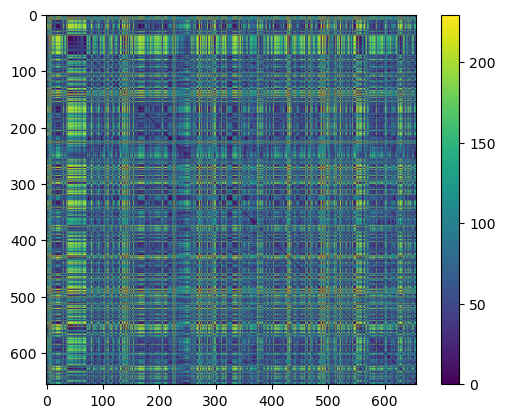

In [8]:
GeomClustering = analysis.GeomClustering(distance_measure='euclidean')
distance_matrix = GeomClustering.calculate_distance_matrix(subtraj_lists)
distance_matrix

GeomClustering.plot_distance_matrix()

In [9]:
distance_matrix.mean()
distance_matrix.max()
distance_matrix.min()

distance_matrix.size

np.float64(85.85457485715867)

np.float64(229.47017723377547)

np.float64(0.0)

430336

In [10]:

# Get upper triangular indices (excluding diagonal)
upper_tri_indices = np.triu_indices_from(distance_matrix, k=1)

# Create DataFrame with distance values
distance_df = pd.DataFrame({
    'distance_id': [f"{i}_{j}" for i, j in zip(upper_tri_indices[0], upper_tri_indices[1])],
    'distance': distance_matrix[upper_tri_indices]
})

# Display first few rows
print(distance_df.head())
distance_df.shape


  distance_id    distance
0         0_1  205.875708
1         0_2   99.423787
2         0_3  205.875708
3         0_4  138.095283
4         0_5   12.079724


(214840, 2)

<Figure size 1000x600 with 0 Axes>

(array([3.463e+03, 2.363e+03, 1.615e+03, 1.931e+03, 1.258e+03, 1.019e+03,
        8.750e+02, 9.450e+02, 9.290e+02, 1.483e+03, 2.376e+03, 1.547e+03,
        2.333e+03, 2.087e+03, 2.228e+03, 1.082e+03, 9.230e+02, 7.410e+02,
        7.390e+02, 7.710e+02, 7.800e+02, 9.370e+02, 9.390e+02, 9.050e+02,
        9.430e+02, 1.071e+03, 1.072e+03, 1.305e+03, 1.477e+03, 1.534e+03,
        1.478e+03, 1.864e+03, 1.737e+03, 1.675e+03, 1.523e+03, 1.717e+03,
        1.894e+03, 1.820e+03, 2.021e+03, 1.880e+03, 1.903e+03, 1.872e+03,
        2.306e+03, 1.906e+03, 2.068e+03, 2.397e+03, 2.023e+03, 2.562e+03,
        1.958e+03, 2.118e+03, 2.121e+03, 1.995e+03, 2.311e+03, 1.724e+03,
        1.946e+03, 1.647e+03, 1.383e+03, 1.662e+03, 1.553e+03, 1.548e+03,
        1.463e+03, 1.401e+03, 1.479e+03, 1.603e+03, 1.323e+03, 1.210e+03,
        1.424e+03, 1.515e+03, 1.940e+03, 1.963e+03, 1.925e+03, 1.794e+03,
        1.408e+03, 1.507e+03, 1.448e+03, 1.257e+03, 1.331e+03, 1.027e+03,
        8.360e+02, 9.860e+02, 1.026e+0

Text(0.5, 1.0, 'Distribution of Trajectory Distances')

Text(0.5, 0, 'Distance Value')

Text(0, 0.5, 'Frequency')

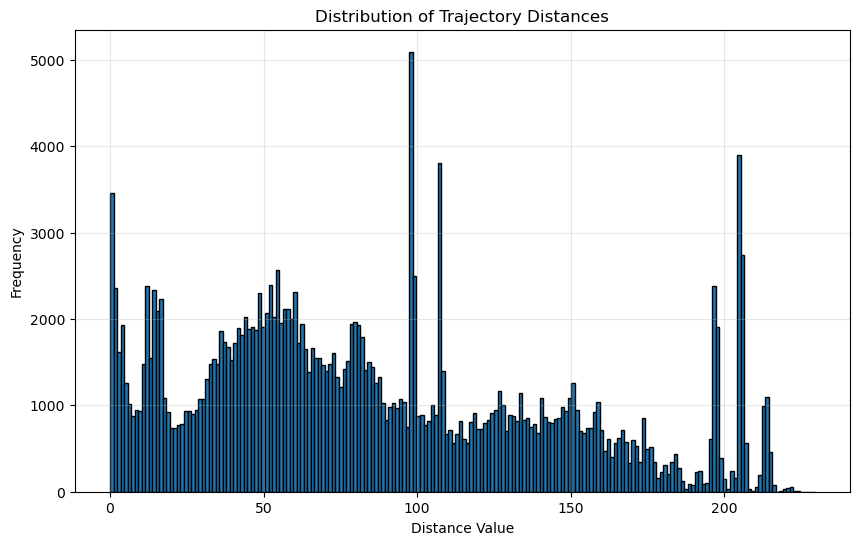

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(distance_df["distance"], bins=200, edgecolor='black')
plt.title('Distribution of Trajectory Distances')
plt.xlabel('Distance Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()


### Clustering



In [28]:
labels = GeomClustering.cluster_trajectories()

In [29]:
subtraj_lists.__len__()
labels.__len__()

656

656

In [30]:
# Convert labels array to DataFrame
clusters_df = pd.DataFrame({
    'trajectory': subtraj_lists,
    'cluster': labels
})

clusters_df.cluster.unique()
clusters_df.cluster.value_counts()

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

cluster
-1     424
 1      44
 5      30
 0      27
 9      22
 2      19
 4      16
 12     12
 3       9
 6       9
 7       8
 13      7
 10      7
 15      6
 11      6
 8       5
 14      5
Name: count, dtype: int64

In [32]:
clusters_df

,trajectory,cluster
0,"[[1.485320687294, -9.4896125793457], [1.939880...",-1
1,"[[-1.7045998573303, -9.4968166351318], [-2.045...",0
2,"[[0.0, -9.4989032745361], [0.0, -9.49890327453...",1
3,"[[-1.7045998573303, -9.4968166351318], [-2.045...",0
4,"[[0.0, -9.4989032745361], [0.0, -9.49890327453...",-1
...,...,...
651,"[[0.0, -9.4989032745361], [0.0, -9.49890327453...",-1
652,"[[0.0, -9.4989032745361], [0.0, -9.49890327453...",-1
653,"[[0.0, -9.4989032745361], [0.0, -9.49890327453...",-1
654,"[[0.0, -9.4989032745361], [0.0, -9.49890327453...",-1
